In [15]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import mplhep as hep
import matplotlib.ticker as mticker

hep.style.use(["CMS", "firamath"])

formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-3, 3))
plt.rcParams.update({"font.size": 12})
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["grid.color"] = "#CCCCCC"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["figure.edgecolor"] = "none"

# Checks on signal samples

In [16]:
import sys

sys.path.append("..")

import hist
import os
import utils
from postprocessing.postprocessing import Region, weight_shifts, bb_assignment
from utils import ShapeVar, CUT_MAX_VAL
from hh_vars import samples, data_key, bg_keys, sig_keys

In [17]:
# automatically reloads imported files on edits
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
year = "2022EE"
samples[year]

{'hh4b': ['GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_TSG'],
 'qcd': ['QCD_PT'],
 'ttbar': ['TTto2L2Nu', 'TTtoLNu2Q', 'TTto4Q'],
 'gghtobb': ['GluGluHto2B_PT-200_M-125'],
 'vbfhtobb': ['VBFHto2B_M-125_dipoleRecoilOn'],
 'vhtobb': ['WplusH_Hto2B_Wto2Q_M-125',
  'WplusH_Hto2B_WtoLNu_M-125',
  'WminusH_Hto2B_Wto2Q_M-125',
  'WminusH_Hto2B_WtoLNu_M-125',
  'ZH_Hto2B_Zto2Q_M-125',
  'ggZH_Hto2B_Zto2Q_M-125',
  'ggZH_Hto2B_Zto2L_M-125',
  'ggZH_Hto2B_Zto2Nu_M-125'],
 'tthtobb': ['ttHto2B_M-125'],
 'diboson': ['ZZ', 'WW', 'WZ'],
 'vjets': ['Wto2Q-3Jets_HT-200to400',
  'Wto2Q-3Jets_HT-400to600',
  'Wto2Q-3Jets_HT-600to800',
  'Wto2Q-3Jets_HT-800',
  'Zto2Q-4Jets_HT-200to400',
  'Zto2Q-4Jets_HT-400to600',
  'Zto2Q-4Jets_HT-600to800',
  'Zto2Q-4Jets_HT-800'],
 'data': ['Run2022F', 'Run2022G']}

In [34]:
year = "2022EE"
samples_year = samples[year].copy()

# define dictionary with directories of files (this can be configured in a yaml file later in the script)
sig_keys = ["hh4b"]
for key in list(samples_year.keys()):
    if key not in "vhtobb" and key not in sig_keys:
        del samples_year[key]

MAIN_DIR = "../../../"
path_to_dir = f"{MAIN_DIR}/../data/skimmer/Oct26/"
# path_to_dir_signal = f"{MAIN_DIR}/../data/skimmer/Nov6fix/"
path_to_dir_signal = f"{MAIN_DIR}/../data/skimmer/Nov6fix2/"

sample_dirs = {path_to_dir: samples_year}

#hh_dict = {'hh4b': ['GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_TSG']}
#samples_year = {**samples_year, **hh_dict}
#sample_dirs[path_to_dir_signal] = hh_dict

# make plot and template directory
date = "23Nov6"
plot_dir = f"{MAIN_DIR}/plots/PostProcessing/{date}/{year}"
template_dir = f"templates/{date}/"
_ = os.system(f"mkdir -p {plot_dir}")
_ = os.system(f"mkdir -p {template_dir}/cutflows/{year}")

In [35]:
samples_year

{'hh4b': ['GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_TSG'],
 'vhtobb': ['WplusH_Hto2B_Wto2Q_M-125',
  'WplusH_Hto2B_WtoLNu_M-125',
  'WminusH_Hto2B_Wto2Q_M-125',
  'WminusH_Hto2B_WtoLNu_M-125',
  'ZH_Hto2B_Zto2Q_M-125',
  'ggZH_Hto2B_Zto2Q_M-125',
  'ggZH_Hto2B_Zto2L_M-125',
  'ggZH_Hto2B_Zto2Nu_M-125']}

In [36]:
sample_dirs

{'../../..//../data/skimmer/Oct26/': {'hh4b': ['GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_TSG'],
  'vhtobb': ['WplusH_Hto2B_Wto2Q_M-125',
   'WplusH_Hto2B_WtoLNu_M-125',
   'WminusH_Hto2B_Wto2Q_M-125',
   'WminusH_Hto2B_WtoLNu_M-125',
   'ZH_Hto2B_Zto2Q_M-125',
   'ggZH_Hto2B_Zto2Q_M-125',
   'ggZH_Hto2B_Zto2L_M-125',
   'ggZH_Hto2B_Zto2Nu_M-125']}}

In [37]:
pt_cut = 300

filters = [
    [
        ("('ak8FatJetPt', '0')", ">=", pt_cut),
        ("('ak8FatJetPt', '1')", ">=", pt_cut),
        ("('ak8FatJetMsd', '0')", ">=", 60),
        ("('ak8FatJetMsd', '1')", ">=", 60),
        ("('ak8FatJetPNetXbb', '0')", ">=", 0.8),
    ],
    [
        ("('ak8FatJetPt', '0')", ">=", pt_cut),
        ("('ak8FatJetPt', '1')", ">=", pt_cut),
        ("('ak8FatJetMsd', '0')", ">=", 60),
        ("('ak8FatJetMsd', '1')", ">=", 60),
        ("('ak8FatJetPNetXbb', '1')", ">=", 0.8),
    ],
]

# save cutflow as pandas table
cutflow = pd.DataFrame(index=list(samples_year.keys()))

# dictionary that will contain all information (from all samples)
events_dict = {}
for input_dir, samples_dict in sample_dirs.items():
    events_dict = {
        **events_dict,
        # this function will load files (only the columns selected), apply filters and compute a weight per event
        **utils.load_samples(
            input_dir,
            samples_dict,
            year,
            filters=filters,
        ),
    }

utils.add_to_cutflow(events_dict, "Preselection", "weight", cutflow)
print("\n", cutflow)

bb_masks = bb_assignment(events_dict)

Loading GluGlutoHHto4B_kl-1p00_kt-1p00_c2-0p00_TuneCP5_13p6TeV_TSG
Loading WplusH_Hto2B_WtoLNu_M-125
Loading ggZH_Hto2B_Zto2L_M-125
Loading WplusH_Hto2B_Wto2Q_M-125
Loading WminusH_Hto2B_Wto2Q_M-125
Loading ggZH_Hto2B_Zto2Q_M-125
Loading ZH_Hto2B_Zto2Q_M-125
Loading WminusH_Hto2B_WtoLNu_M-125
Loading ggZH_Hto2B_Zto2Nu_M-125

         Preselection
hh4b       25.672323
vhtobb    153.927990


In [38]:
len(events_dict["hh4b"])

1252

In [32]:
events_dict["hh4b"].single_weight_genweight

,0
0,1.0
1,-1.0
2,1.0
3,1.0
4,1.0
...,...
330,1.0
331,-1.0
332,1.0
333,1.0


In [24]:
events_dict["hh4b"].ak8FatJetPNetMass

,0,1
0,136.499373,132.154852
1,167.506618,138.095004
2,144.642311,126.005272
3,138.330349,137.369297
4,131.119335,125.881152
...,...,...
330,132.903534,127.713083
331,121.127440,154.613417
332,139.695932,118.806034
333,135.156258,148.948439


In [25]:
bb_masks

{'vhtobb':           0      1
 0     False   True
 1     False   True
 2     False   True
 3     False   True
 4     False   True
 ...     ...    ...
 2599  False   True
 2600  False   True
 2601  False   True
 2602   True  False
 2603   True  False
 
 [84975 rows x 2 columns],
 'hh4b':          0      1
 0    False   True
 1    False   True
 2     True  False
 3    False   True
 4    False   True
 ..     ...    ...
 330  False   True
 331   True  False
 332   True  False
 333   True  False
 334   True  False
 
 [335 rows x 2 columns]}

In [26]:
events_dict["hh4b"]["ak8FatJetPNetMass"].values[bb_masks["hh4b"] ^ (int("0") == 1)].squeeze()

array([132.15485171, 138.09500407, 144.6423113 , 137.36929741,
       125.88115249, 119.37584961, 140.87352904, 126.33270561,
       113.16783426, 147.98341491, 127.83940771,  91.31249044,
       139.10303586, 120.44596149, 141.56586098, 108.45799549,
       142.08754401, 128.6660808 , 142.23483234, 119.50011902,
       138.77478153, 142.44446645, 135.61154851, 119.58620011,
       115.68705032, 130.82874301, 132.18866517, 121.54764986,
        97.74086934, 127.53329984, 129.88438382, 173.03222361,
       109.96888693, 120.78297497, 145.5903593 , 122.97553211,
       131.55681184, 152.79515624, 152.97730879, 130.03702114,
       155.51098952, 129.49340032, 134.31714693, 139.32892106,
       130.73337688, 127.97090119, 174.48834852, 131.83201593,
       125.2473958 , 149.13995729, 132.94148811, 128.22518677,
       111.33476467,  74.90898786, 110.22388888, 118.84341437,
       125.52160933, 140.7021329 , 136.0176616 , 135.77650681,
       102.37580195, 125.57914777, 153.25681369, 141.64

In [27]:
for key, events in events_dict.items():
    if key == data_key:
        events["weight_nopileup"] = events["weight"]
        events["weight_notrigger"] = events["weight"]
    else:
        events["weight_nopileup"] = events["weight"] / events["single_weight_pileup"]
        events["weight_notrigger_nopileup"] = events["weight"] / (
            events["single_weight_trigsf_2jet"] * events["single_weight_pileup"]
        )

## Check mass

Text(0, 1, 'Events')

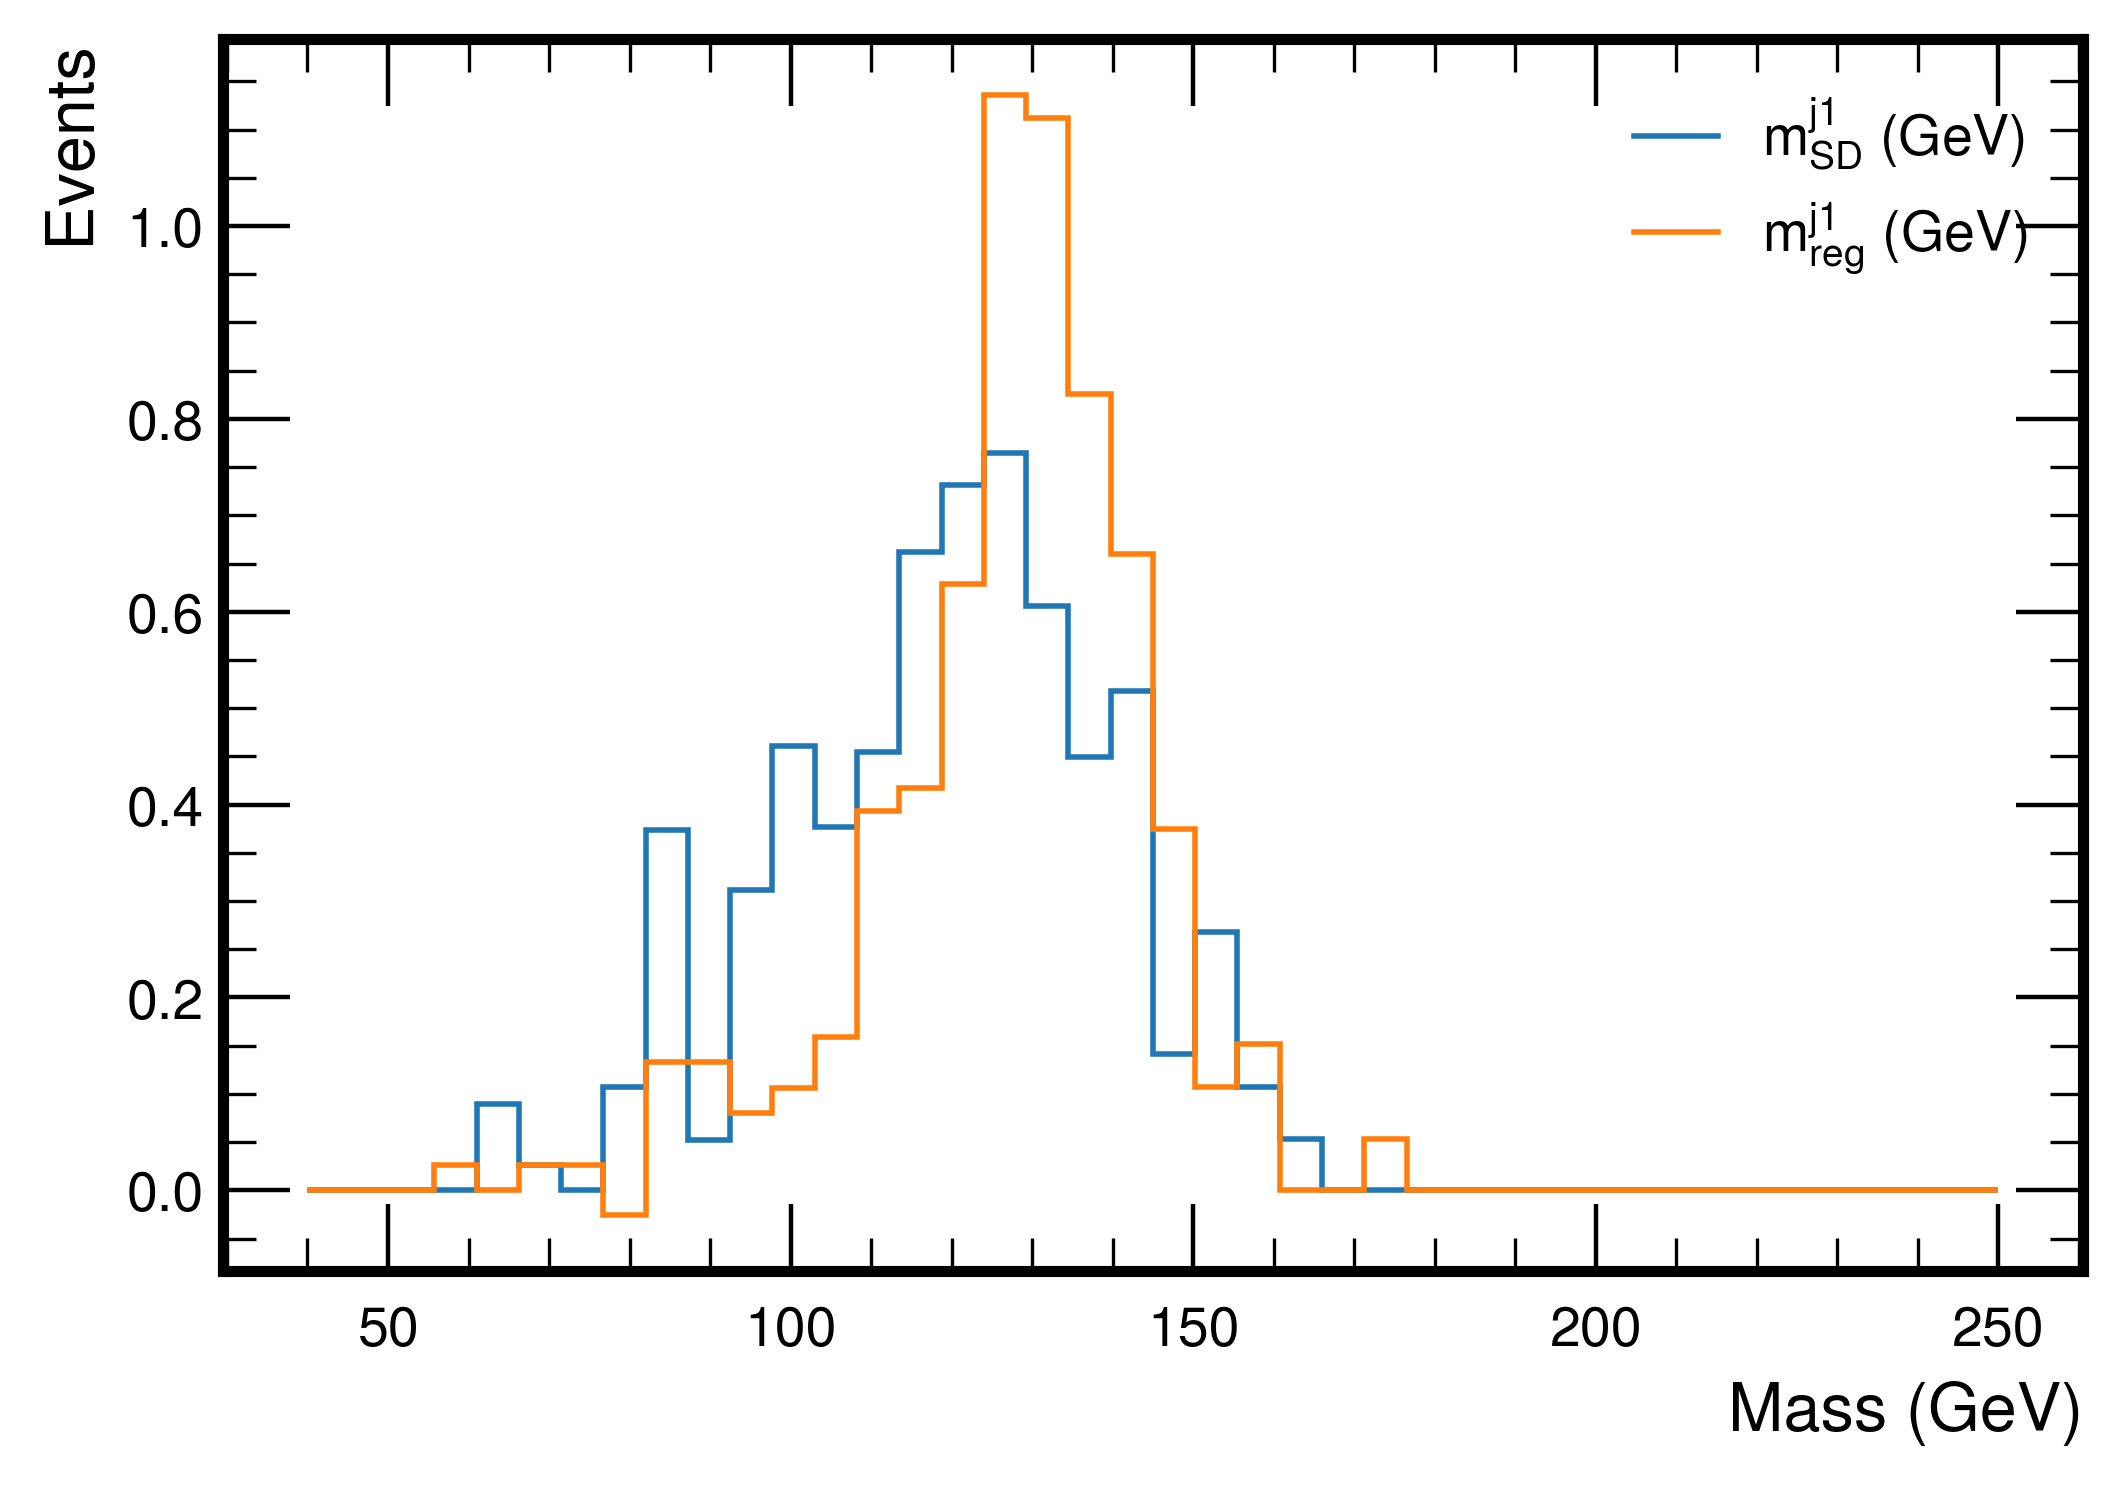

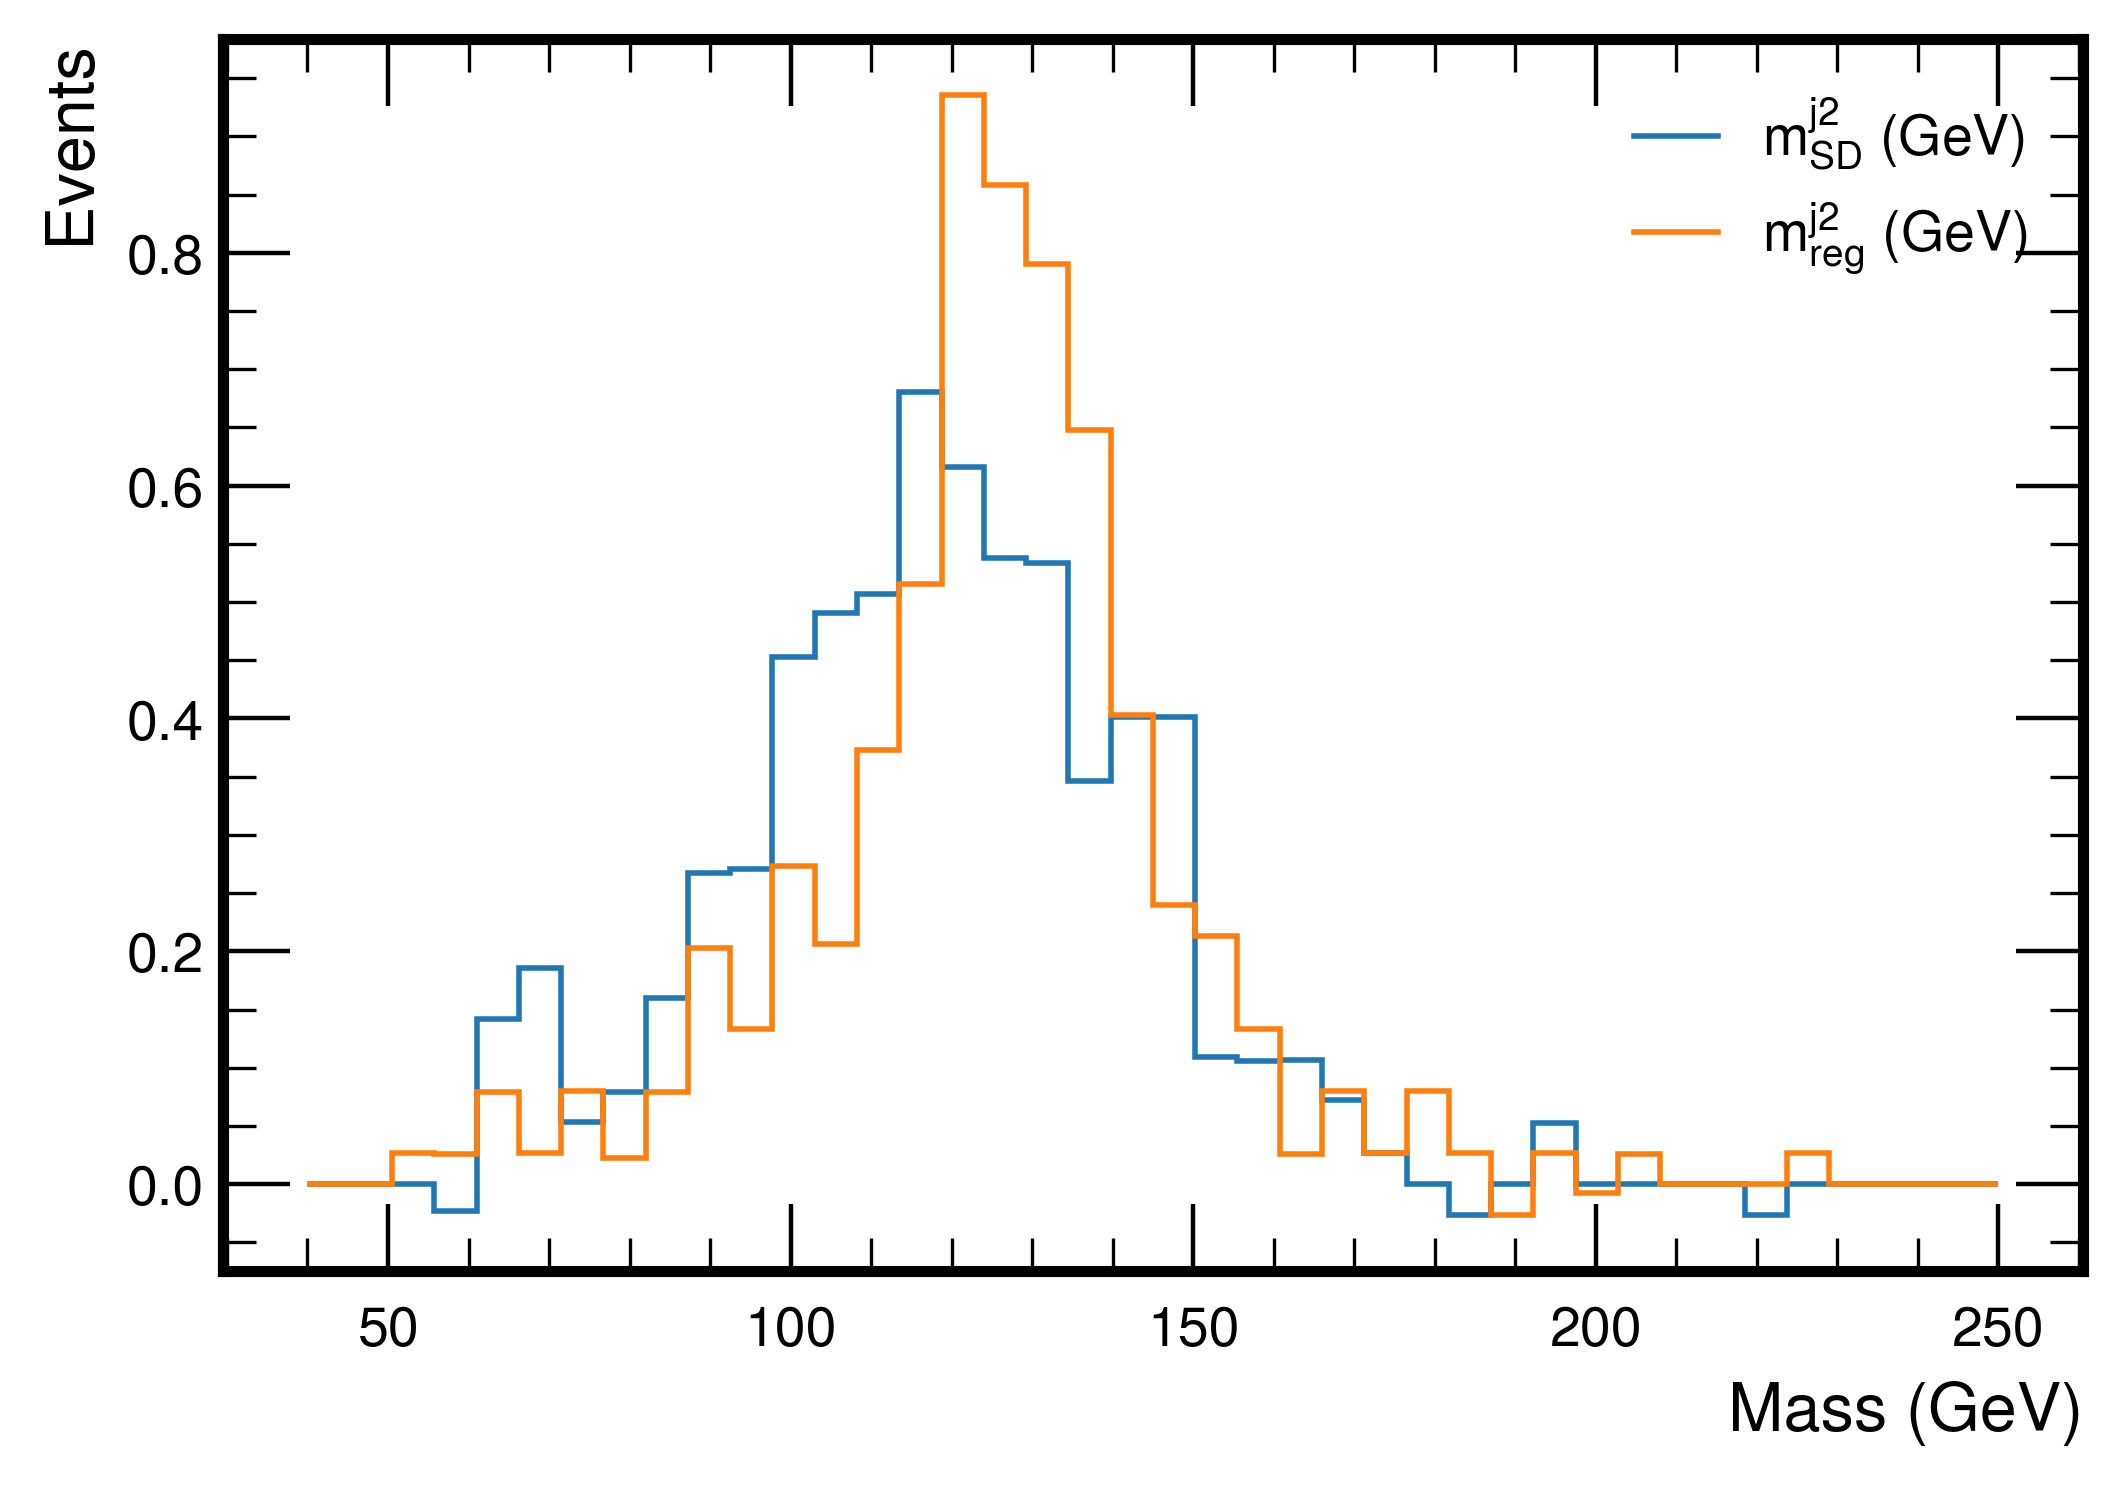

In [28]:
sig_key = "hh4b"
plots = {
    "bb0FatJetPNetMass": r"$m_{reg}^{j1}$ (GeV)",
    "bb1FatJetPNetMass": r"$m_{reg}^{j2}$ (GeV)",
    "bb0FatJetMsd": r"$m_{SD}^{j1}$ (GeV)",
    "bb1FatJetMsd": r"$m_{SD}^{j2}$ (GeV)",
}

mass_axis = hist.axis.Regular(40, 40, 250, name="mass", label=r"Mass [GeV]")
cat_axis = hist.axis.StrCategory([], name="cat", growth=True)
hist_m = hist.Hist(mass_axis, cat_axis)

for key in plots.keys():
    weight = utils.get_feat(events_dict[sig_key], "weight")
    pu_weight = utils.get_feat(events_dict[sig_key], "weight")
    if key == "hh4b":
        weight = weight / pu_weight
    hist_m.fill(
        mass=utils.get_feat(events_dict[sig_key], key, bb_masks[sig_key]),
        cat=key,
        weight=weight,
    )

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
hep.histplot(hist_m[{"cat": "bb0FatJetMsd"}], ax=ax, label=plots["bb0FatJetMsd"])
hep.histplot(hist_m[{"cat": "bb0FatJetPNetMass"}], ax=ax, label=plots["bb0FatJetPNetMass"])
ax.legend()
ax.set_xlabel("Mass (GeV)")
ax.set_ylabel("Events")

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
hep.histplot(hist_m[{"cat": "bb1FatJetMsd"}], ax=ax, label=plots["bb1FatJetMsd"])
hep.histplot(hist_m[{"cat": "bb1FatJetPNetMass"}], ax=ax, label=plots["bb1FatJetPNetMass"])
ax.legend()
ax.set_xlabel("Mass (GeV)")
ax.set_ylabel("Events")

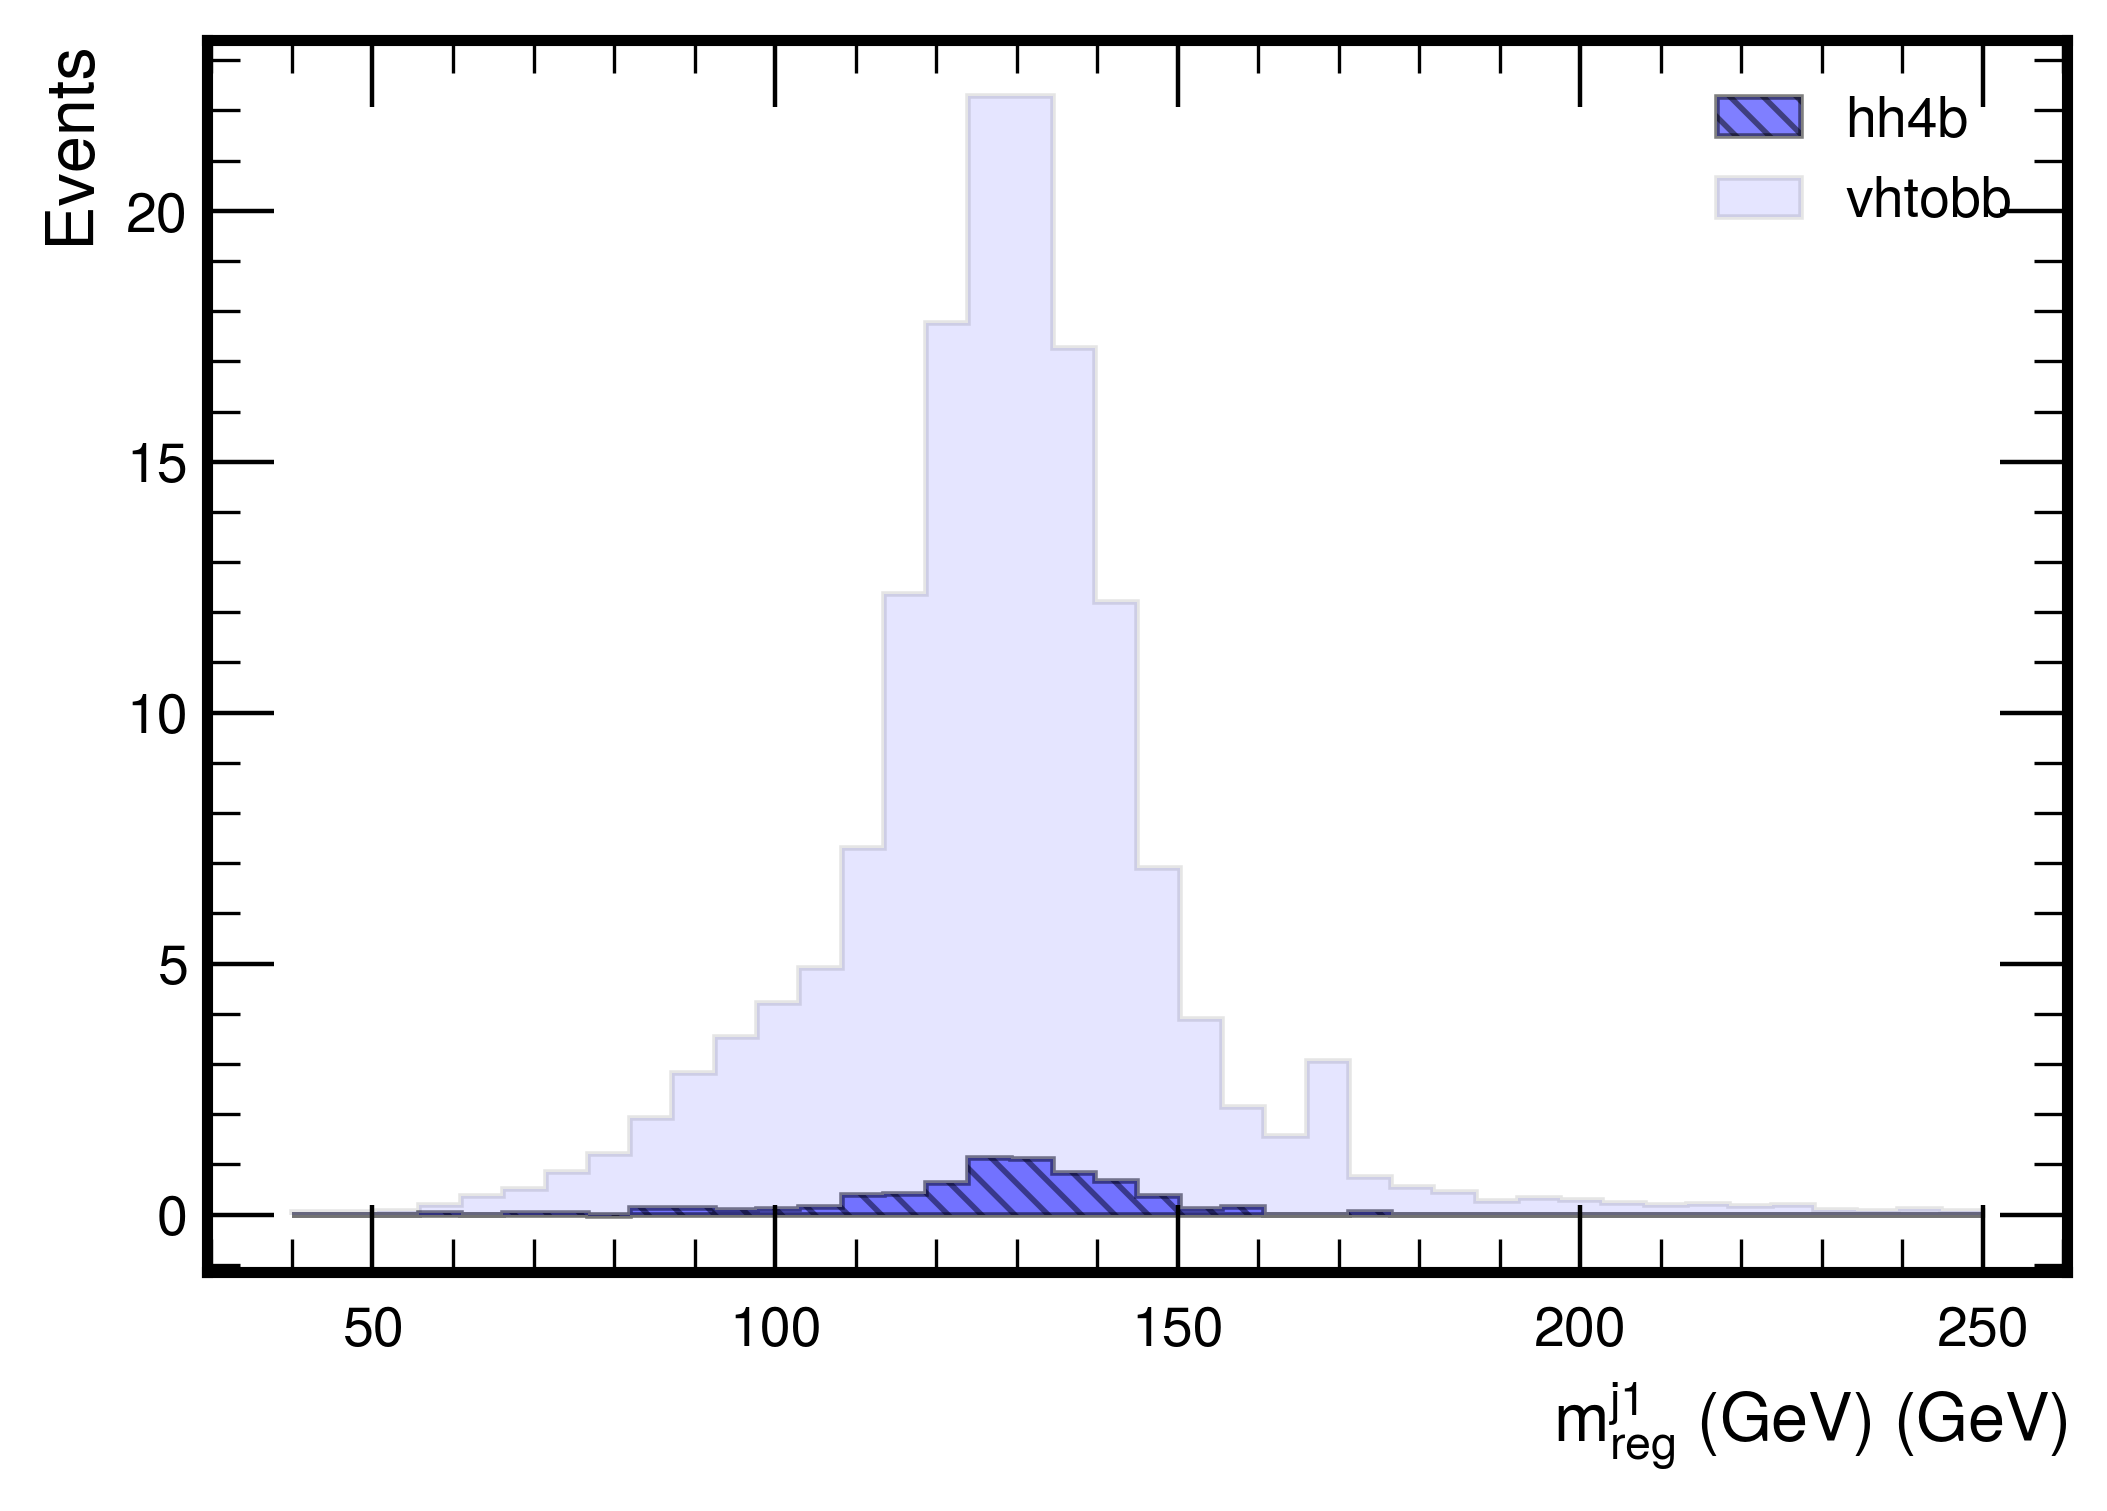

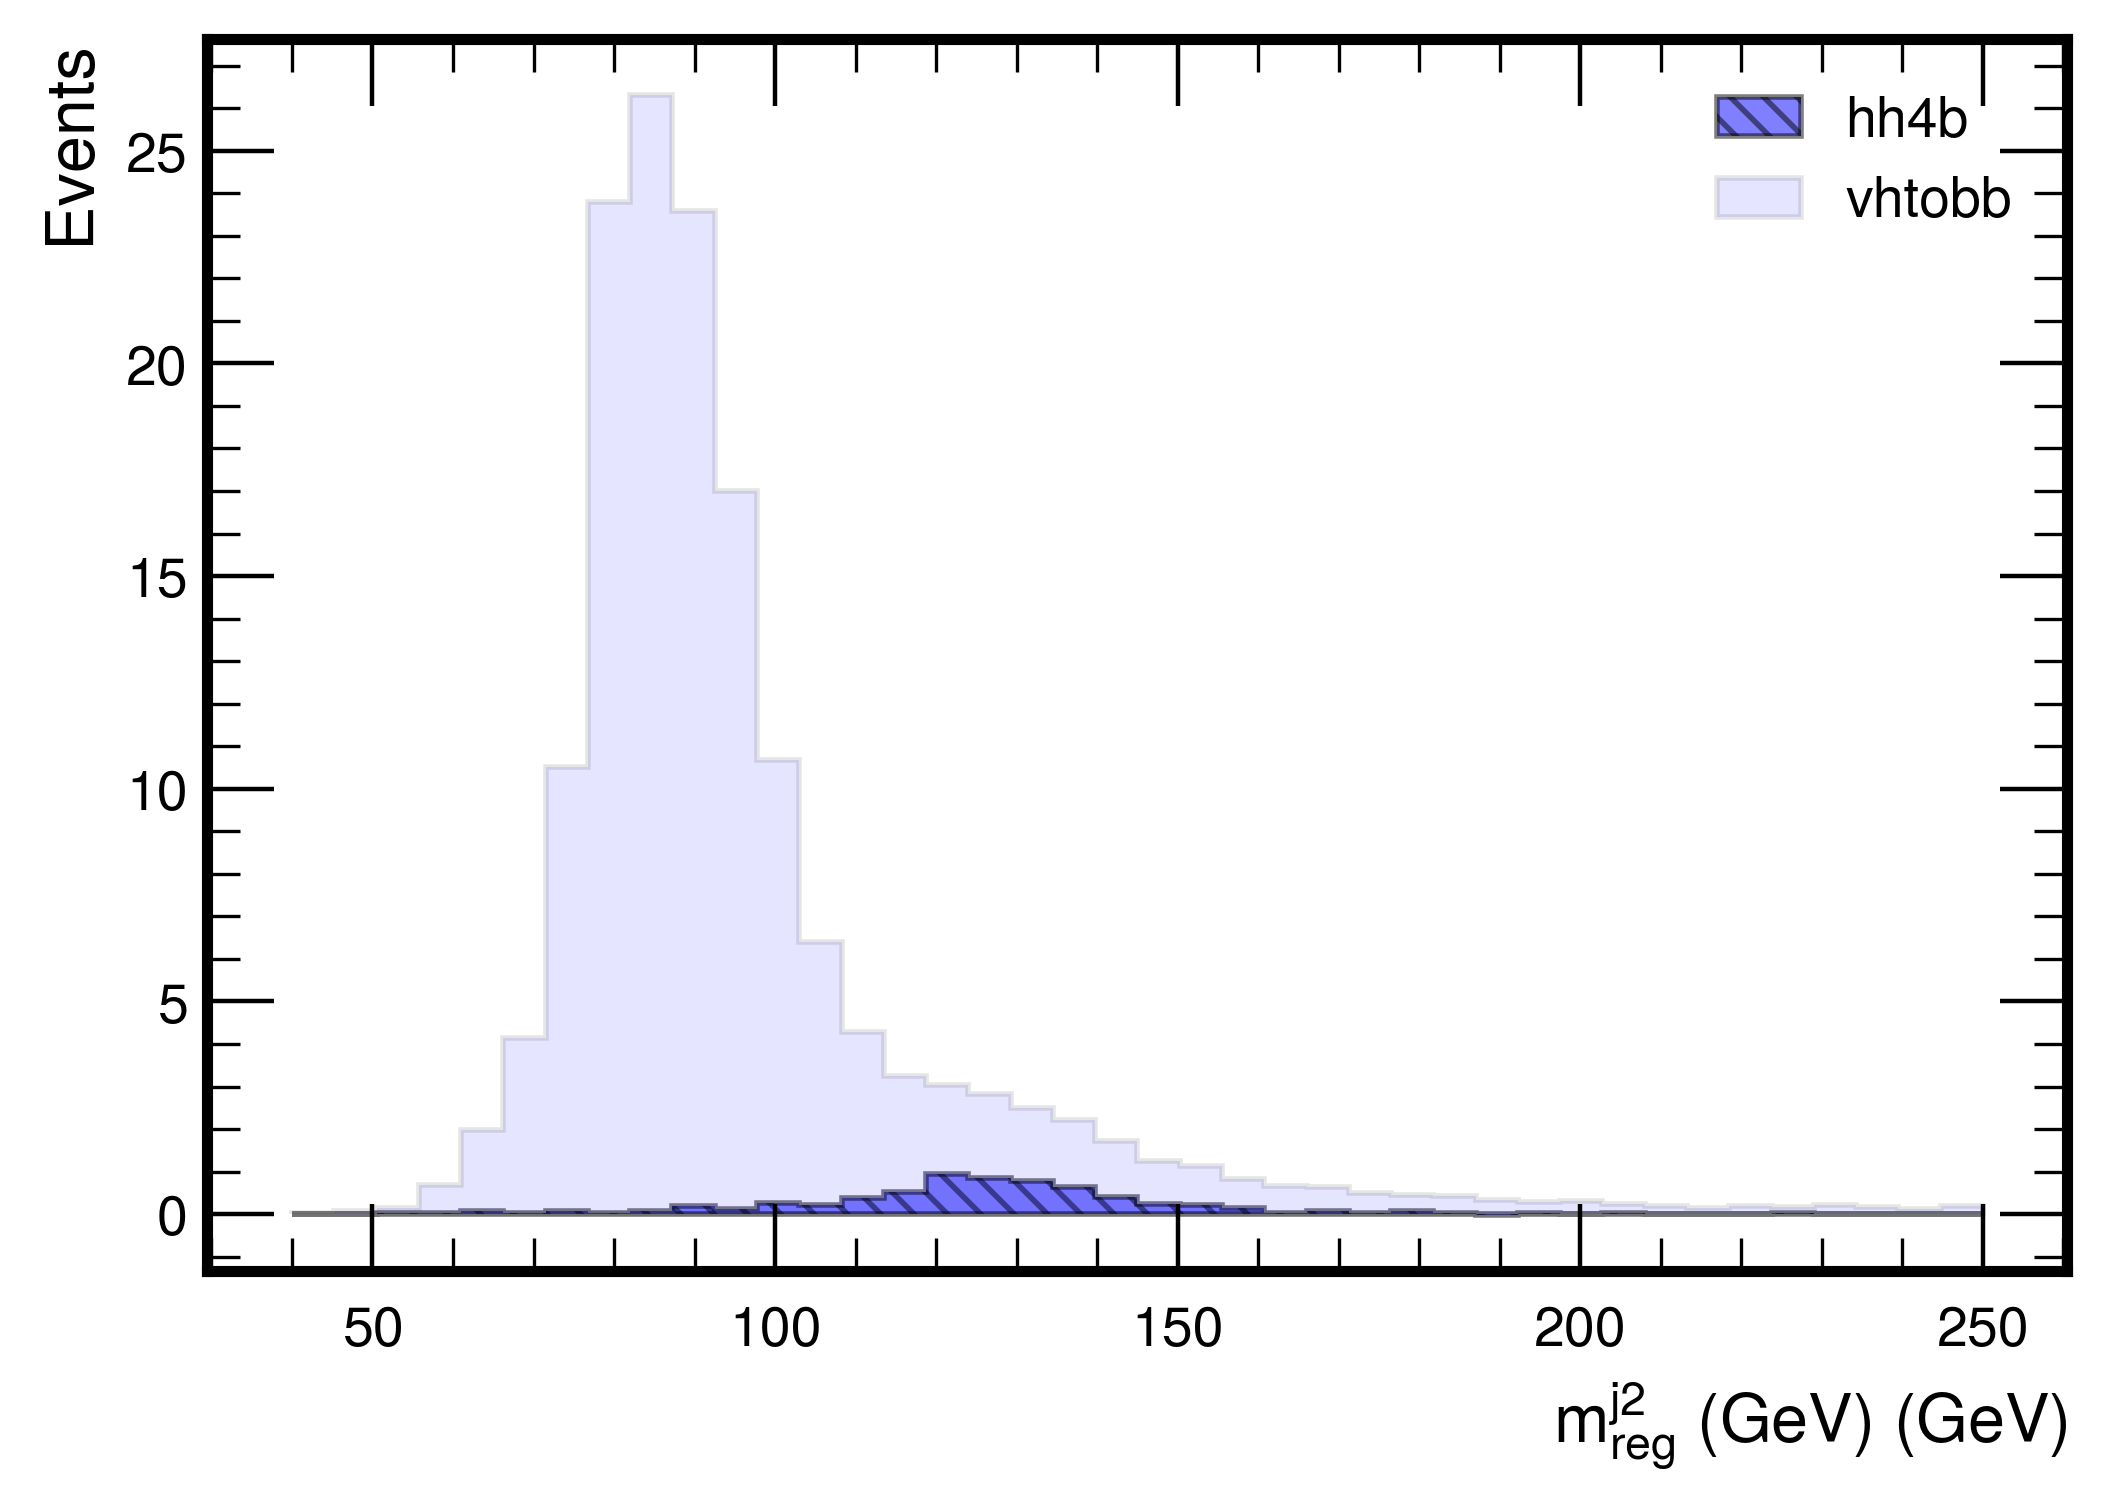

In [29]:
for key in ["bb0FatJetPNetMass", "bb1FatJetPNetMass"]:
    hist_m = hist.Hist(mass_axis, cat_axis)
    for sig_key in ["hh4b", "vhtobb"]:
        weight = utils.get_feat(events_dict[sig_key], "weight")
        pu_weight = utils.get_feat(events_dict[sig_key], "weight")
        if key == "hh4b":
            weight = weight / pu_weight
        hist_m.fill(
            mass=utils.get_feat(events_dict[sig_key], key, bb_masks[sig_key]),
            cat=sig_key,
            weight=weight,
        )

    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    hep.histplot(
        hist_m[{"cat": "hh4b"}],
        ax=ax,
        label="hh4b",
        histtype="fill",
        hatch=r"\\\\",
        alpha=0.5,
        facecolor="blue",
        edgecolor="black",
        linewidth=1,
    )
    hep.histplot(
        hist_m[{"cat": "vhtobb"}],
        ax=ax,
        label="vhtobb",
        histtype="fill",
        alpha=0.1,
        facecolor="blue",
        edgecolor="black",
        linewidth=1,
    )
    ax.legend()
    ax.set_xlabel(f"{plots[key]} (GeV)")
    ax.set_ylabel("Events")

## Check PU weight

hh4b
no PU weight  0.67
with PU weight  6.52
vhtobb
no PU weight  115.91
with PU weight  153.93


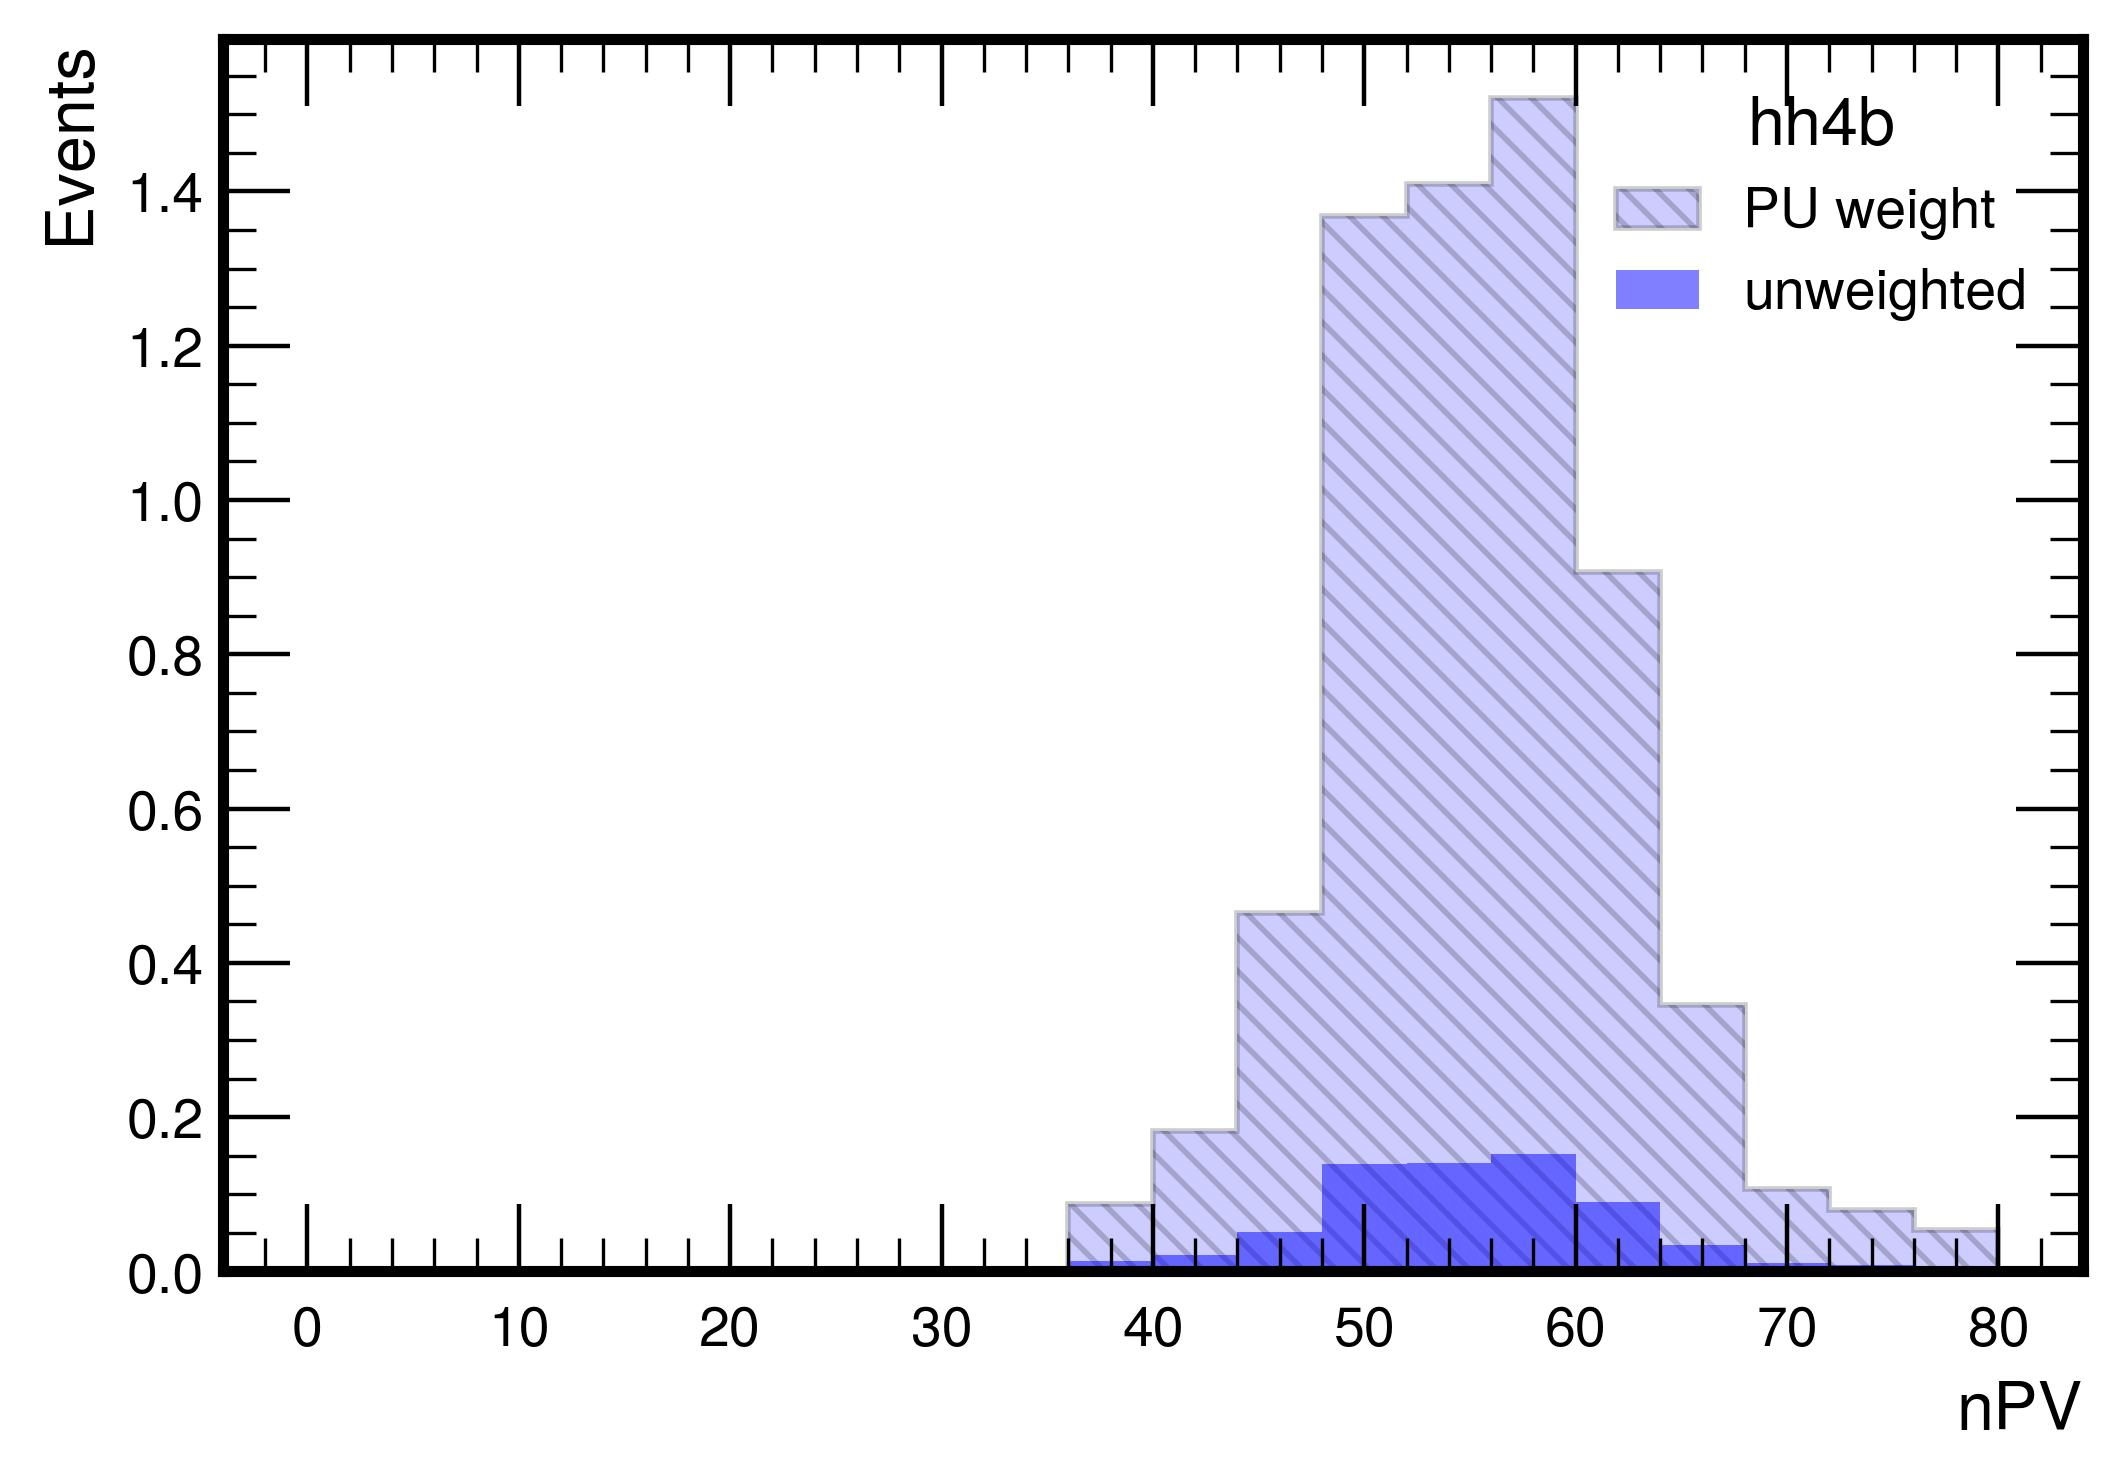

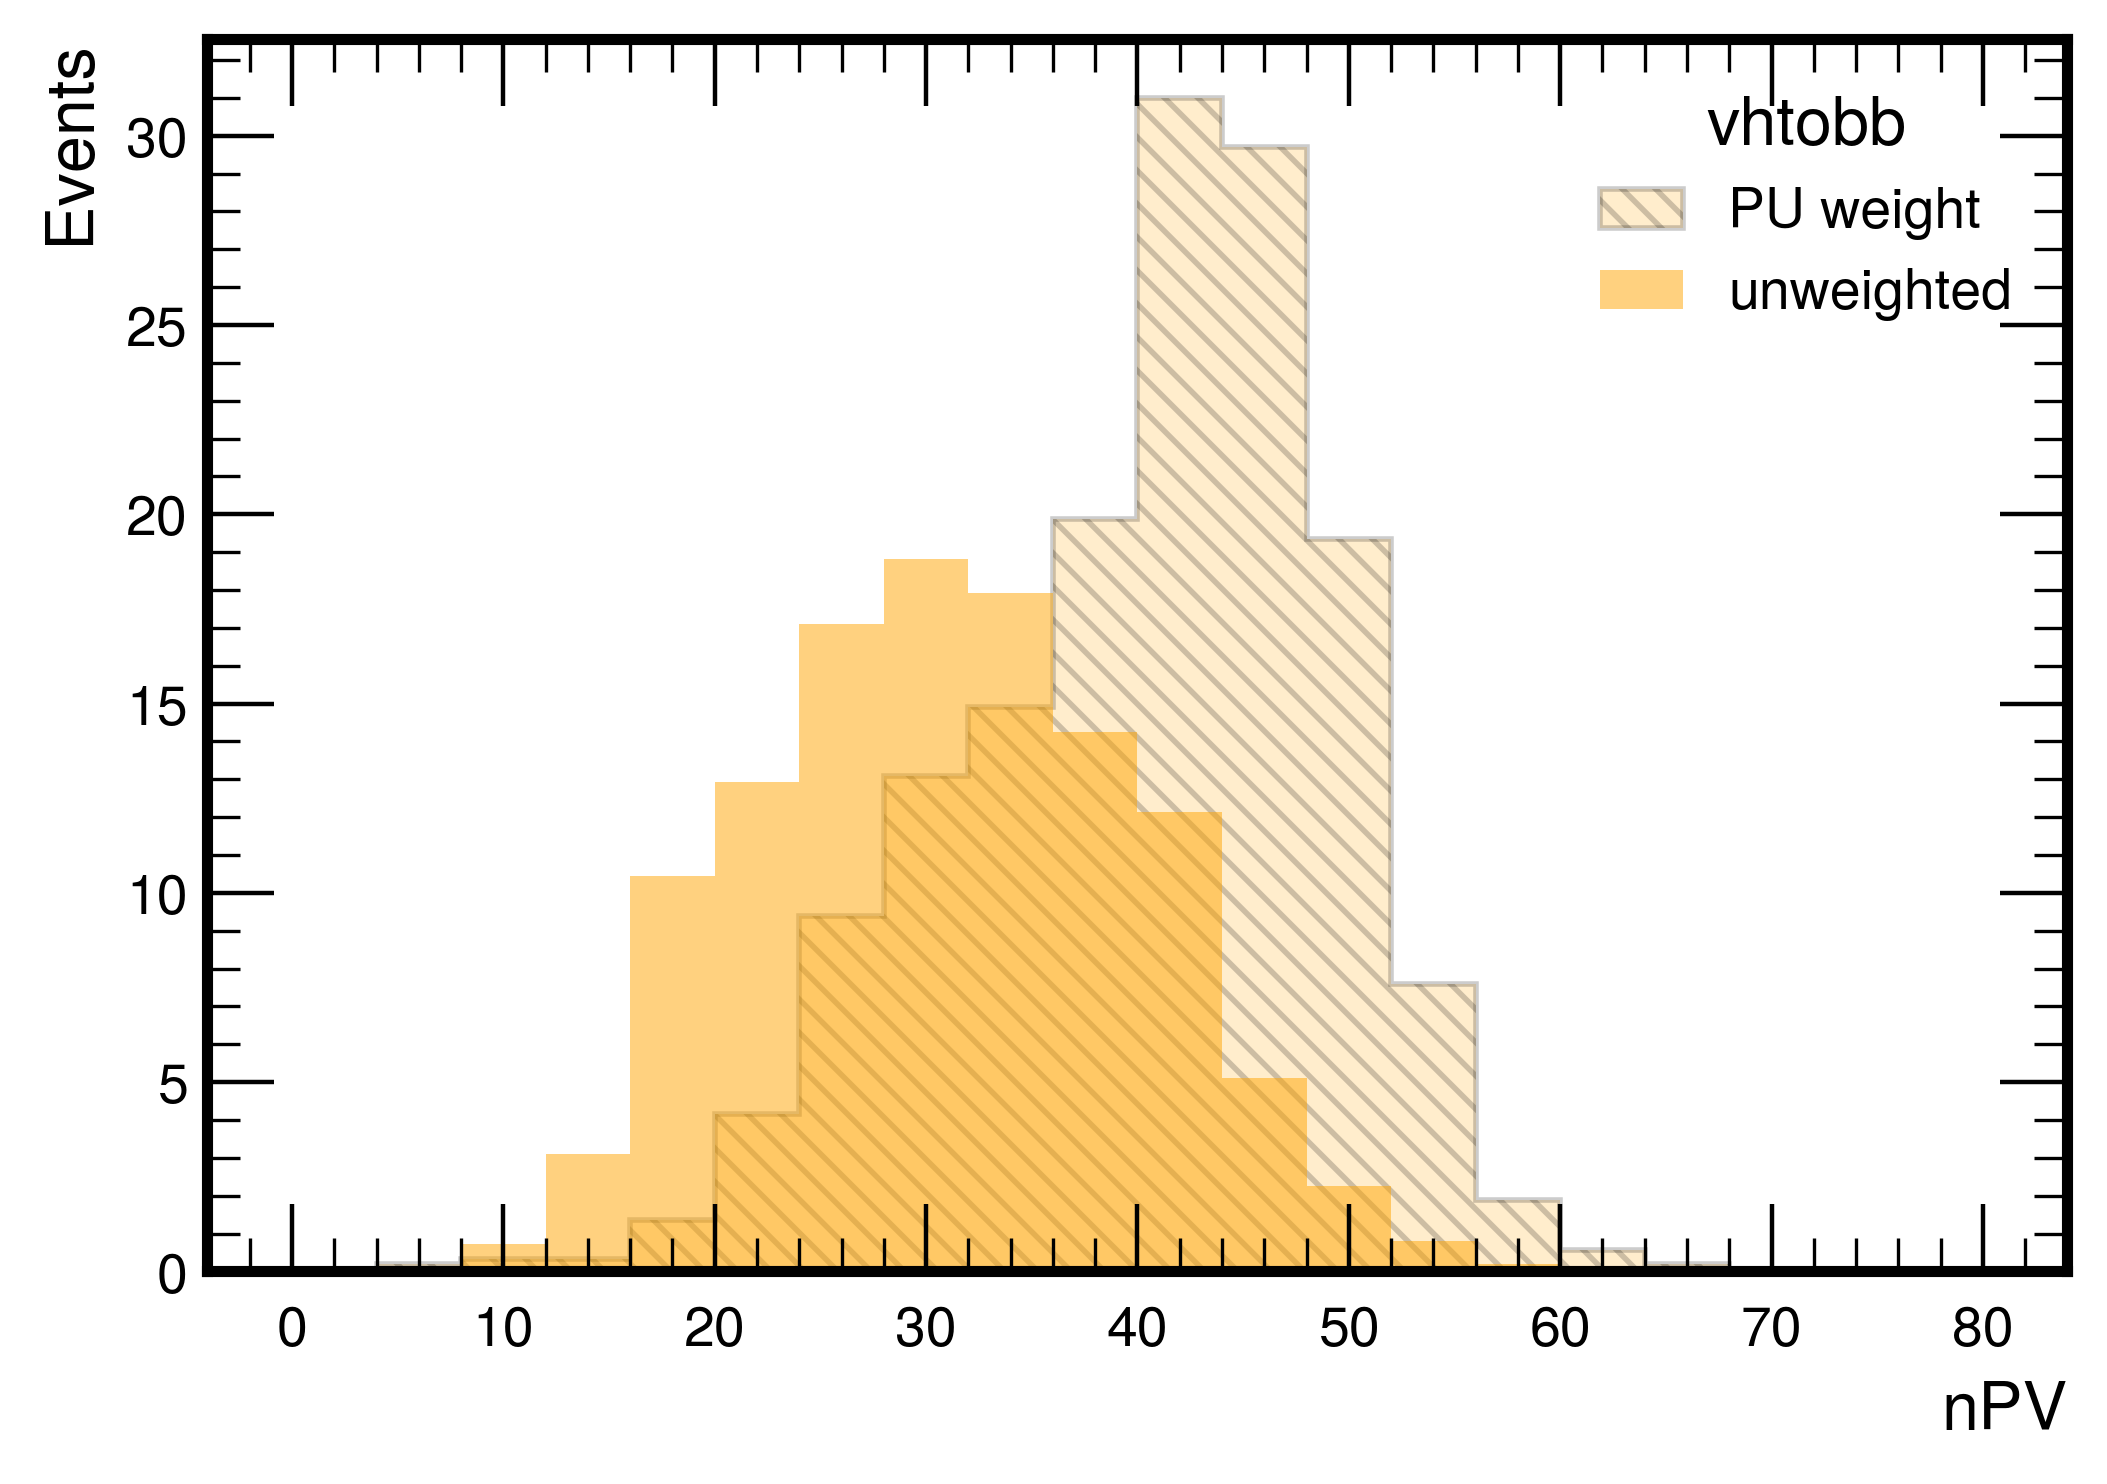

In [30]:
npv_axis = hist.axis.Regular(20, 0, 80, name="npv", label=r"nPV")
colors = {"hh4b": "blue", "vhtobb": "orange"}
for sig_key in ["hh4b", "vhtobb"]:
    h_npv = hist.Hist(npv_axis, cat_axis)
    h_npv.fill(
        npv=utils.get_feat(events_dict[sig_key], "nPV"),
        cat="PU",
        weight=utils.get_feat(events_dict[sig_key], "weight"),
    )
    h_npv.fill(
        npv=utils.get_feat(events_dict[sig_key], "nPV"),
        cat="unweight",
        weight=utils.get_feat(events_dict[sig_key], "weight_nopileup"),
    )

    # print yields
    print(sig_key)
    print("no PU weight ", np.round(h_npv[{"cat": "unweight"}].sum(), 2))
    print("with PU weight ", np.round(h_npv[{"cat": "PU"}].sum(), 2))

    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    hep.histplot(
        h_npv[{"cat": "PU"}],
        ax=ax,
        label="PU weight",
        histtype="fill",
        hatch=r"\\\\",
        alpha=0.2,
        facecolor=colors[sig_key],
        edgecolor="black",
        linewidth=1,
    )
    hep.histplot(
        h_npv[{"cat": "unweight"}],
        ax=ax,
        label="unweighted",
        histtype="fill",
        alpha=0.5,
        facecolor=colors[sig_key],
    )
    ax.legend(title=sig_key)
    ax.set_ylabel("Events")

## Check Trigger weight

Hist(
  Regular(40, 0, 250, name='msd', label='m$_{SD}^{1}$ [GeV]'),
  StrCategory(['trigger', 'unweight'], growth=True, name='cat'),
  storage=Double()) # Sum: 1.3403865960942956
hh4b
no trigger weight  0.67
with trigger weight  0.67
Hist(
  Regular(40, 0, 250, name='msd', label='m$_{SD}^{1}$ [GeV]'),
  StrCategory(['trigger', 'unweight'], growth=True, name='cat'),
  storage=Double()) # Sum: 231.16427035270928 (232.71501879980806 with flow)
vhtobb
no trigger weight  116.03
with trigger weight  115.14


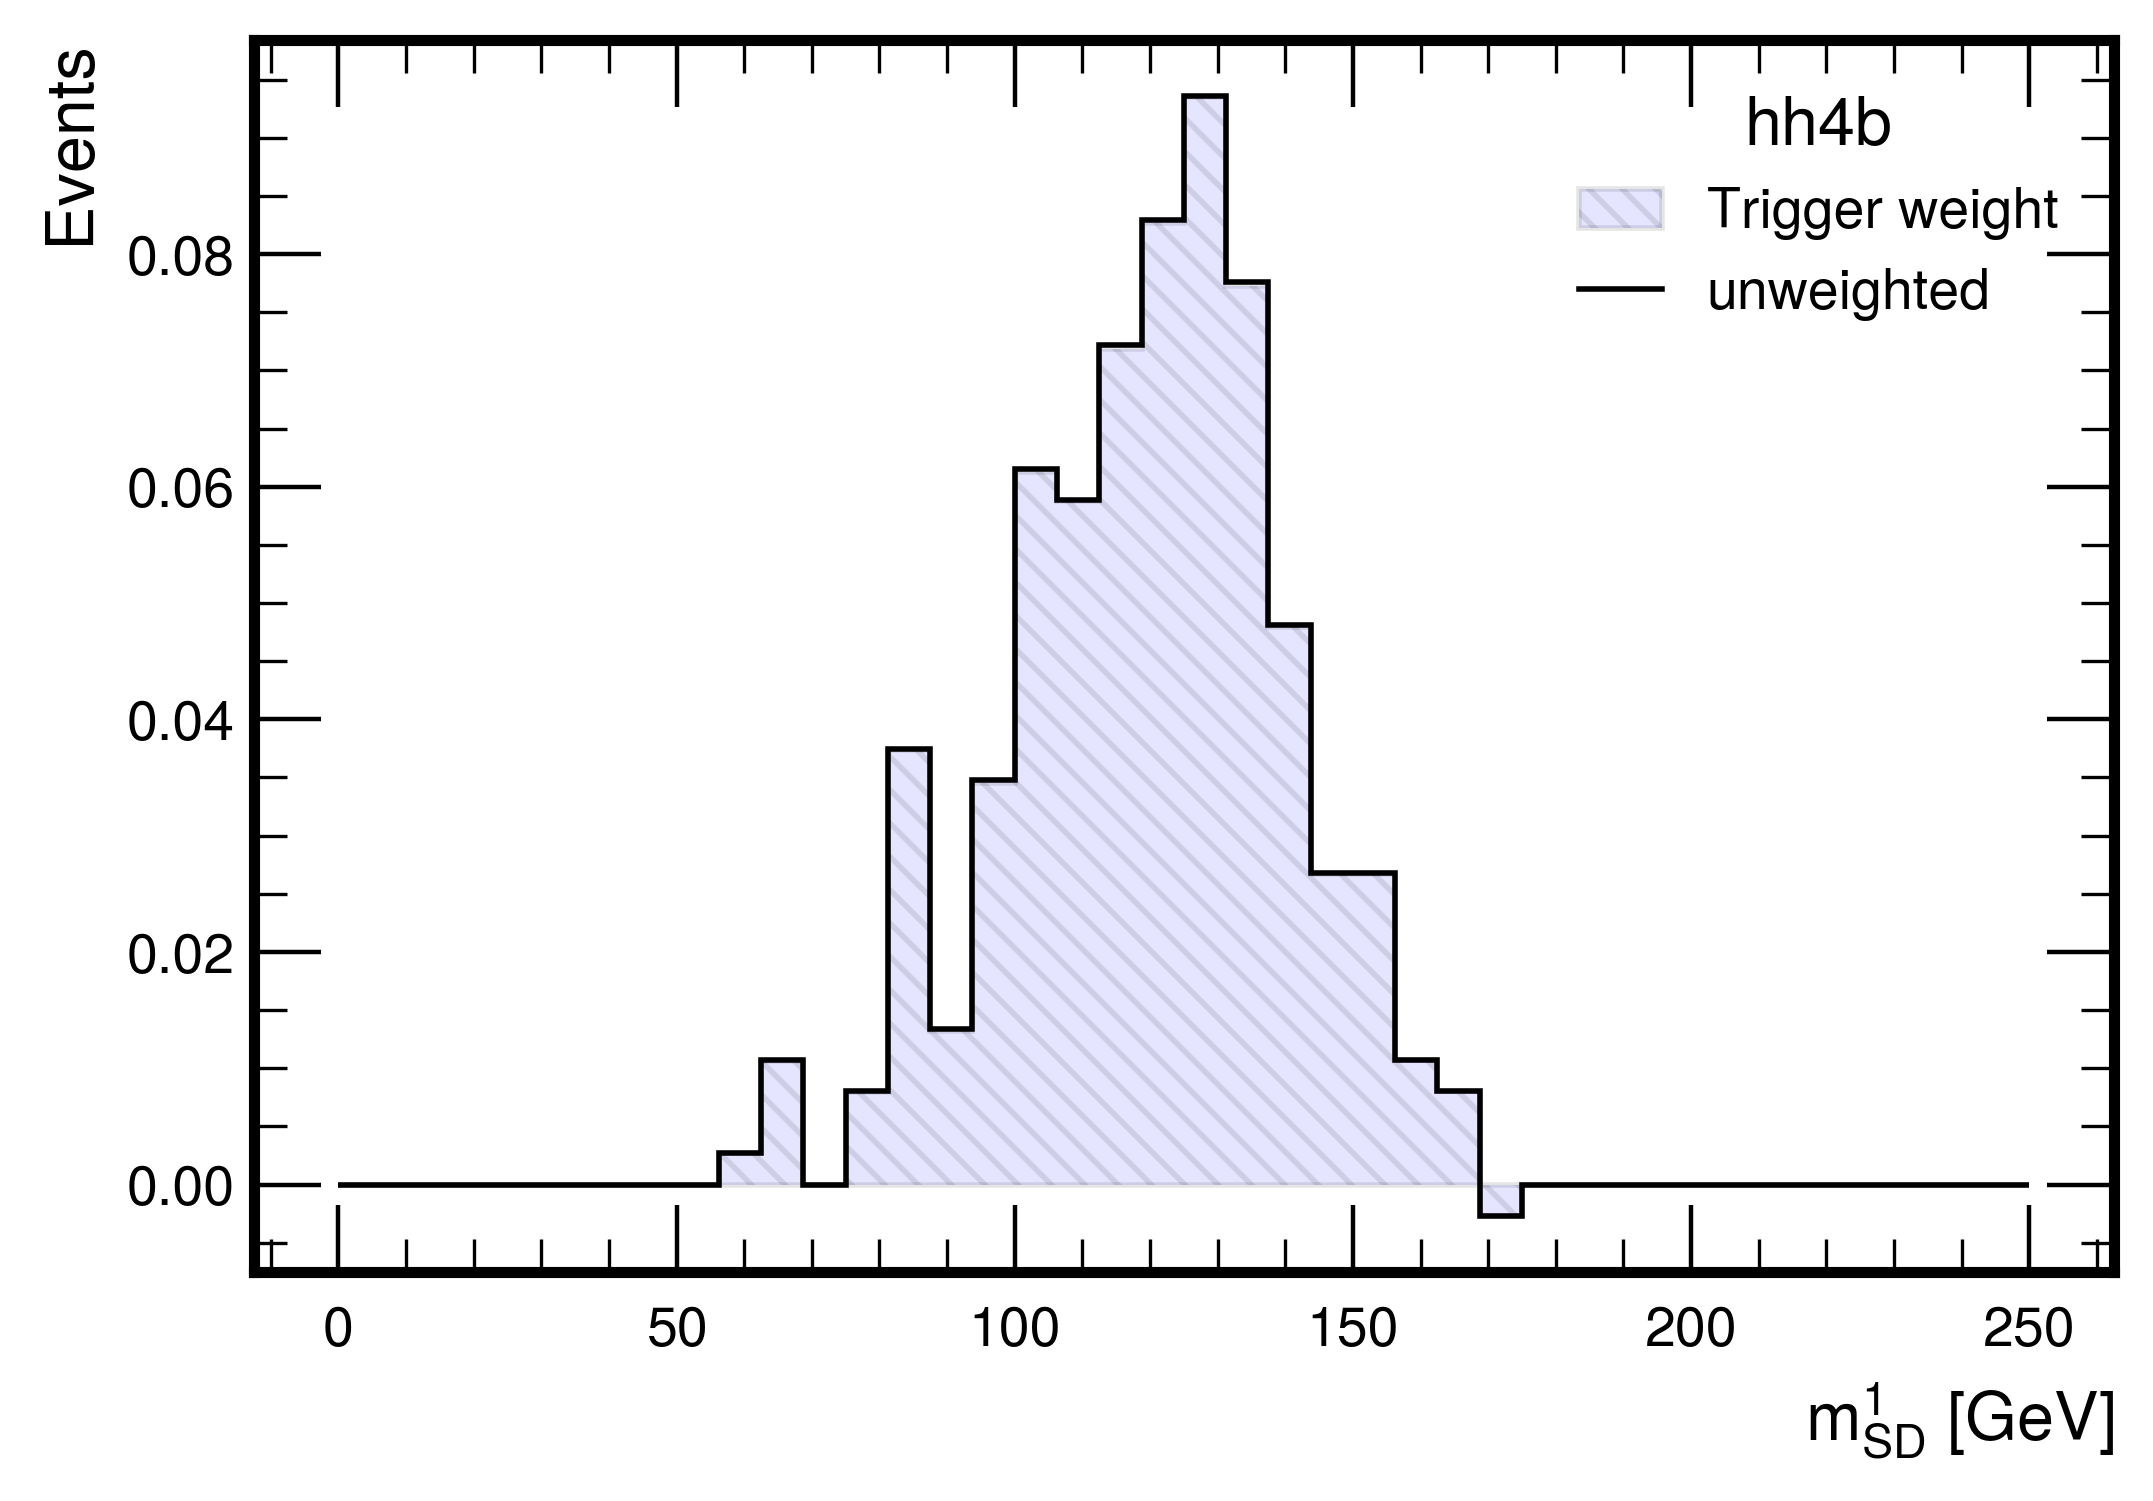

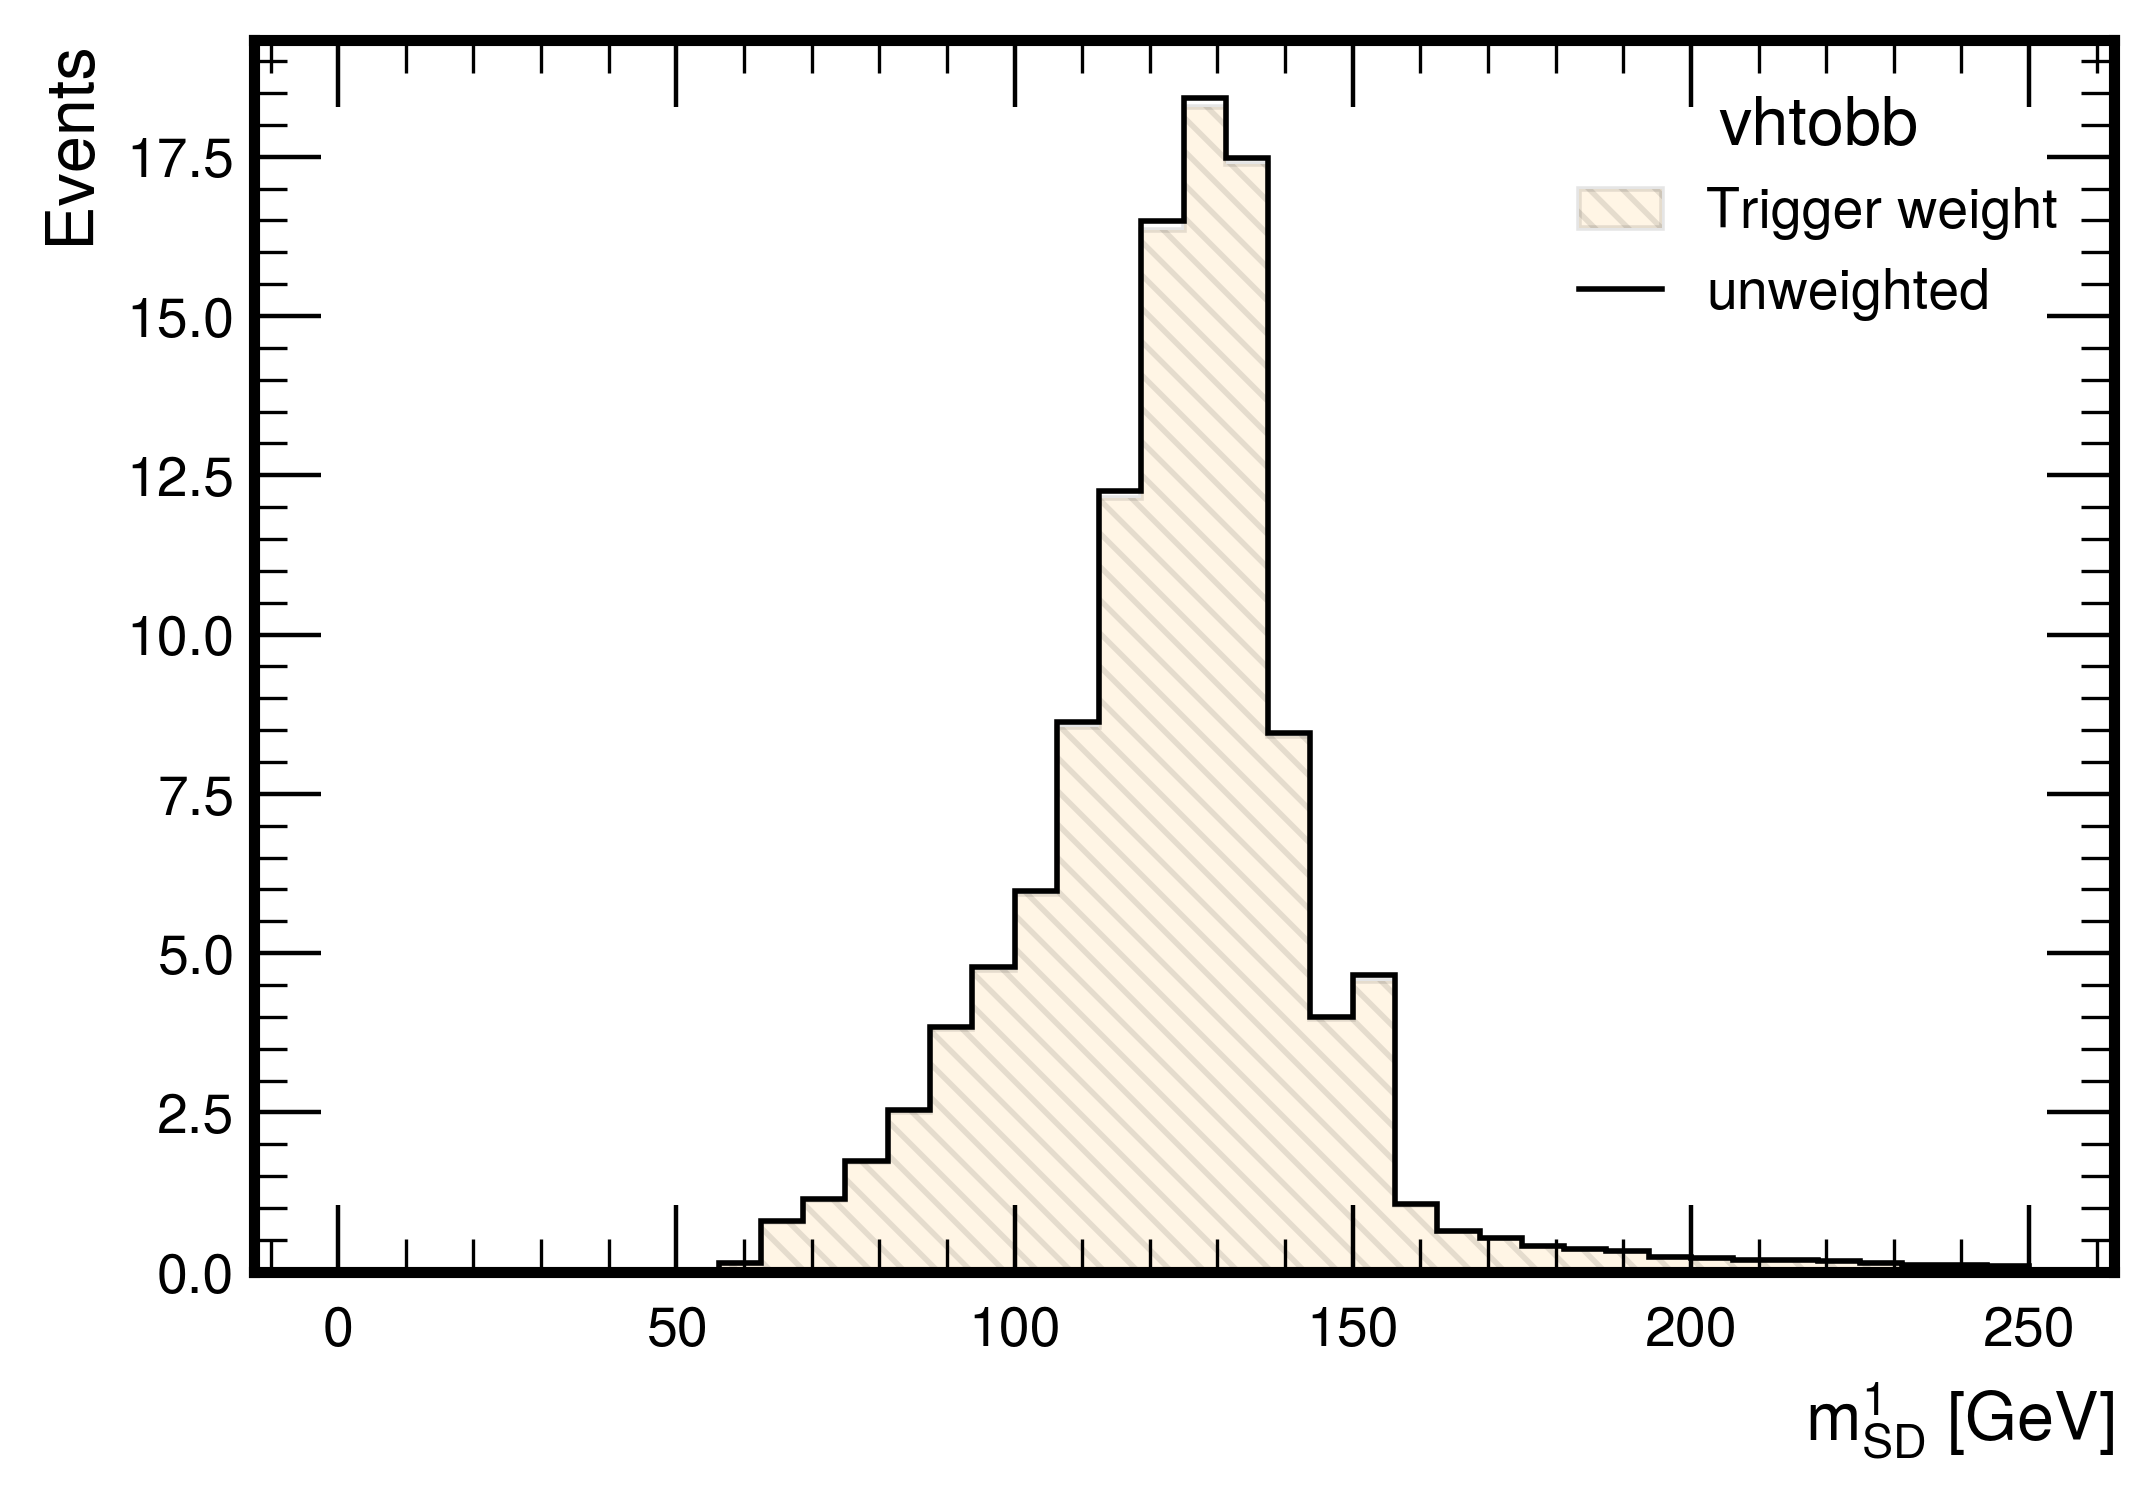

In [31]:
msd_axis = hist.axis.Regular(40, 0, 250, name="msd", label=r"m$_{SD}^{1}$ [GeV]")
colors = {"hh4b": "blue", "vhtobb": "orange"}
for sig_key in ["hh4b", "vhtobb"]:
    h_m = hist.Hist(msd_axis, cat_axis)
    h_m.fill(
        msd=utils.get_feat(events_dict[sig_key], "bb0FatJetMsd", bb_masks[sig_key]),
        cat="trigger",
        weight=utils.get_feat(events_dict[sig_key], "weight_nopileup"),
    )
    h_m.fill(
        msd=utils.get_feat(events_dict[sig_key], "bb0FatJetMsd", bb_masks[sig_key]),
        cat="unweight",
        weight=utils.get_feat(events_dict[sig_key], "weight_notrigger_nopileup"),
    )

    print(h_m)
    # print yields
    print(sig_key)
    print("no trigger weight ", np.round(h_m[{"cat": "unweight"}].sum(), 2))
    print("with trigger weight ", np.round(h_m[{"cat": "trigger"}].sum(), 2))

    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    hep.histplot(
        h_m[{"cat": "trigger"}],
        ax=ax,
        label="Trigger weight",
        histtype="fill",
        hatch=r"\\\\",
        alpha=0.1,
        facecolor=colors[sig_key],
        edgecolor="black",
        linewidth=1,
    )
    hep.histplot(
        h_m[{"cat": "unweight"}],
        ax=ax,
        label="unweighted",
        color=colors[sig_key],
        edgecolor="black",
    )
    ax.legend(title=sig_key)
    ax.set_ylabel("Events")